# Projeto: Pipeline de dados do Telegram

### **Contexto**

* **chatbot**


Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

* **Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

###**Arquitetura**

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o *bot*?
1. Qual o problema ou dúvida mais frequente?
1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
1. Etc.

Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

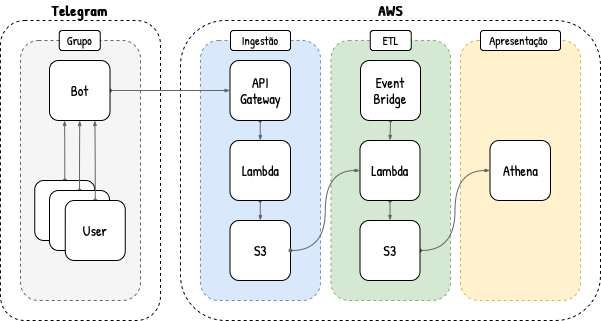

* **Telegram**

O Telegram representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um bot e redirecionadas via webhook do backend do aplicativo para um endpoint (endereço web que aceita requisições HTTP) exposto pelo AWS API Gateway. As mensagens trafegam no corpo ou payload da requisição.

* **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu payload é recebia pelo AWS API Gateway que, por sua vez, as redireciona para o AWS Lambda, servindo assim como seu gatilho. Já o AWS Lambda recebe o payload da requisição em seu parâmetro event, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o payload) e o armazena no AWS S3 particionado por dia.

* **AWS | ETL**

Uma vez ao dia, o AWS Event Bridge aciona o AWS Lambda que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no AWS S3 particionado por dia.

* **AWS | Apresentação**

Por fim, uma tabela do AWS Athena é apontada para o bucket do AWS S3 que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de insights.

## **Sistema transacional**

*   Criaremos uma conta no Telegram.

*   Criamos um bot e salvaremos seu tokken para acesso API HTTP.
* Criar um grupo e adicionar o bot para ele captar as mensagens.
* Acessamos as mensagens captadas pelo bot pela API.


# **Sistema analítico**

### **Ingestão**

A etapa de ingestão é responsável por transferir dados transacionais para ambientes analíticos sem alterar sua estrutura original, como no caso de dados em formato JSON obtidos de uma API REST. Persistir os dados no formato original facilita o reprocessamento. A ingestão pode ocorrer de duas formas: por batch, com blocos de dados em intervalos definidos, ou por streaming, em tempo real. No projeto, as mensagens capturadas pelo bot do Telegram, que retém dados por apenas 24h, devem ser ingeridas via streaming usando um webhook para redirecioná-las a um serviço da AWS. O AWS API Gateway recebe e redireciona os dados para o AWS Lambda, que armazena os dados no formato original em um bucket do AWS S3.

processo:

 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.

**AWS Lambda**

Na etapa de ingestão, o AWS Lambda tem a função de ativamente persistir as mensagens captadas pelo bot do Telegram em um bucket do AWS S3. Para tanto vamos criar uma função que opera da seguinte forma:


 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**
Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

 - **Permissão**

 Por fim, precisamos adicionar a permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

**AWS API Gateway**

Na etapa de ingestão, o AWS API Gateway recebe mensagens do bot do Telegram via webhook e aciona uma função AWS Lambda, passando o conteúdo da mensagem como parâmetro. Para isso, cria-se uma API REST, configurando-a como gatilho da função Lambda, definindo o método POST e habilitando o uso de Lambda Proxy. Após configurar e testar a integração usando a ferramenta de testes do serviço, a API é implantada, gerando seu endereço web. A implantação é feita selecionando "Deploy API", criando um novo stage chamado "dev".

**Telegram**

Vamos configurar o webhook para redirecionar as mensagens para a url do AWS API Gateway.

- **setWebhook**

O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do paramametro url.

Nota: os métodos getUpdates e setWebhook são mutualmente exclusivos, ou seja, enquanto o webhook estiver ativo, o método getUpdates não funcionará. Para desativar o webhook, basta utilizar o método deleteWebhook.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

- **getWebhookInfo**




O método getWebhookInfo retorna as informações sobre o webhook configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

### **ETL**

A etapa de ETL (Extração, Transformação e Carregamento) manipula dados de sistemas transacionais, transformando-os em dados prontos para análise. O processo inclui data wrangling, onde os dados são limpos e deduplicados, e são aplicadas técnicas como particionamento e compressão. No projeto, as mensagens de um único dia serão compactadas em um arquivo orientado a colunas e persistidas em uma camada enriquecida no AWS S3. A função AWS Lambda processará os dados, e o AWS EventBridge será configurado para acionar esse processo diariamente.

 **AWS S3**

 Na etapa de ETL, o AWS S3 tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um bucket. Como padrão, vamos adicionar o sufixo -enriched ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

  **AWS Lambda**

  Na etapa de ETL, o AWS Lambda processa ativamente as mensagens captadas pelo bot do Telegram, armazenadas no bucket do AWS S3 em uma camada crua, e as persiste na camada enriquecida também no S3. A função lista os arquivos JSON da camada crua, faz o download, processa os dados, cria uma tabela com PyArrow, concatena com outras e salva no formato Parquet na camada enriquecida. Esse uso de duas camadas de armazenamento permite reprocessar os dados crus de diversas formas, quantas vezes forem necessárias.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

#O código da função de data wrangling:

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, é necessário configurar duas variáveis de ambiente (AWS_S3_BUCKET e AWS_S3_ENRICHED) para os buckets S3 da camada cru e enriquecida, e adicionar permissão de escrita nos buckets do AWS S3 através do AWS IAM. O tempo limite padrão do AWS Lambda deve ser aumentado para 5 minutos devido ao tempo de IO dos arquivos. Além disso, como o ambiente padrão do Lambda não inclui o pacote PyArrow, será necessário criar uma camada (layer) para adicionar pacotes externos, fazendo o upload do PyArrow em um bucket S3 e conectando essa camada à função.

### **AWS Event Bridge**

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

## **Análise Exploratória de Dados**

**Apresentação**

A etapa de apresentação é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

**AWS Athena**

Na etapa de apresentação, o AWS Athena tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.


criar a tabela:
```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```
adicionar as partições disponíveis:
```sql
MSCK REPAIR TABLE `telegram`;
```
E consulte as 10 primeiras linhas para observar o resultado.
```sql
SELECT * FROM `telegram` LIMIT 10;
```

**Analytics**

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas.

- Quantidade de mensagens por hora por dia da semana por número da semana.
```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

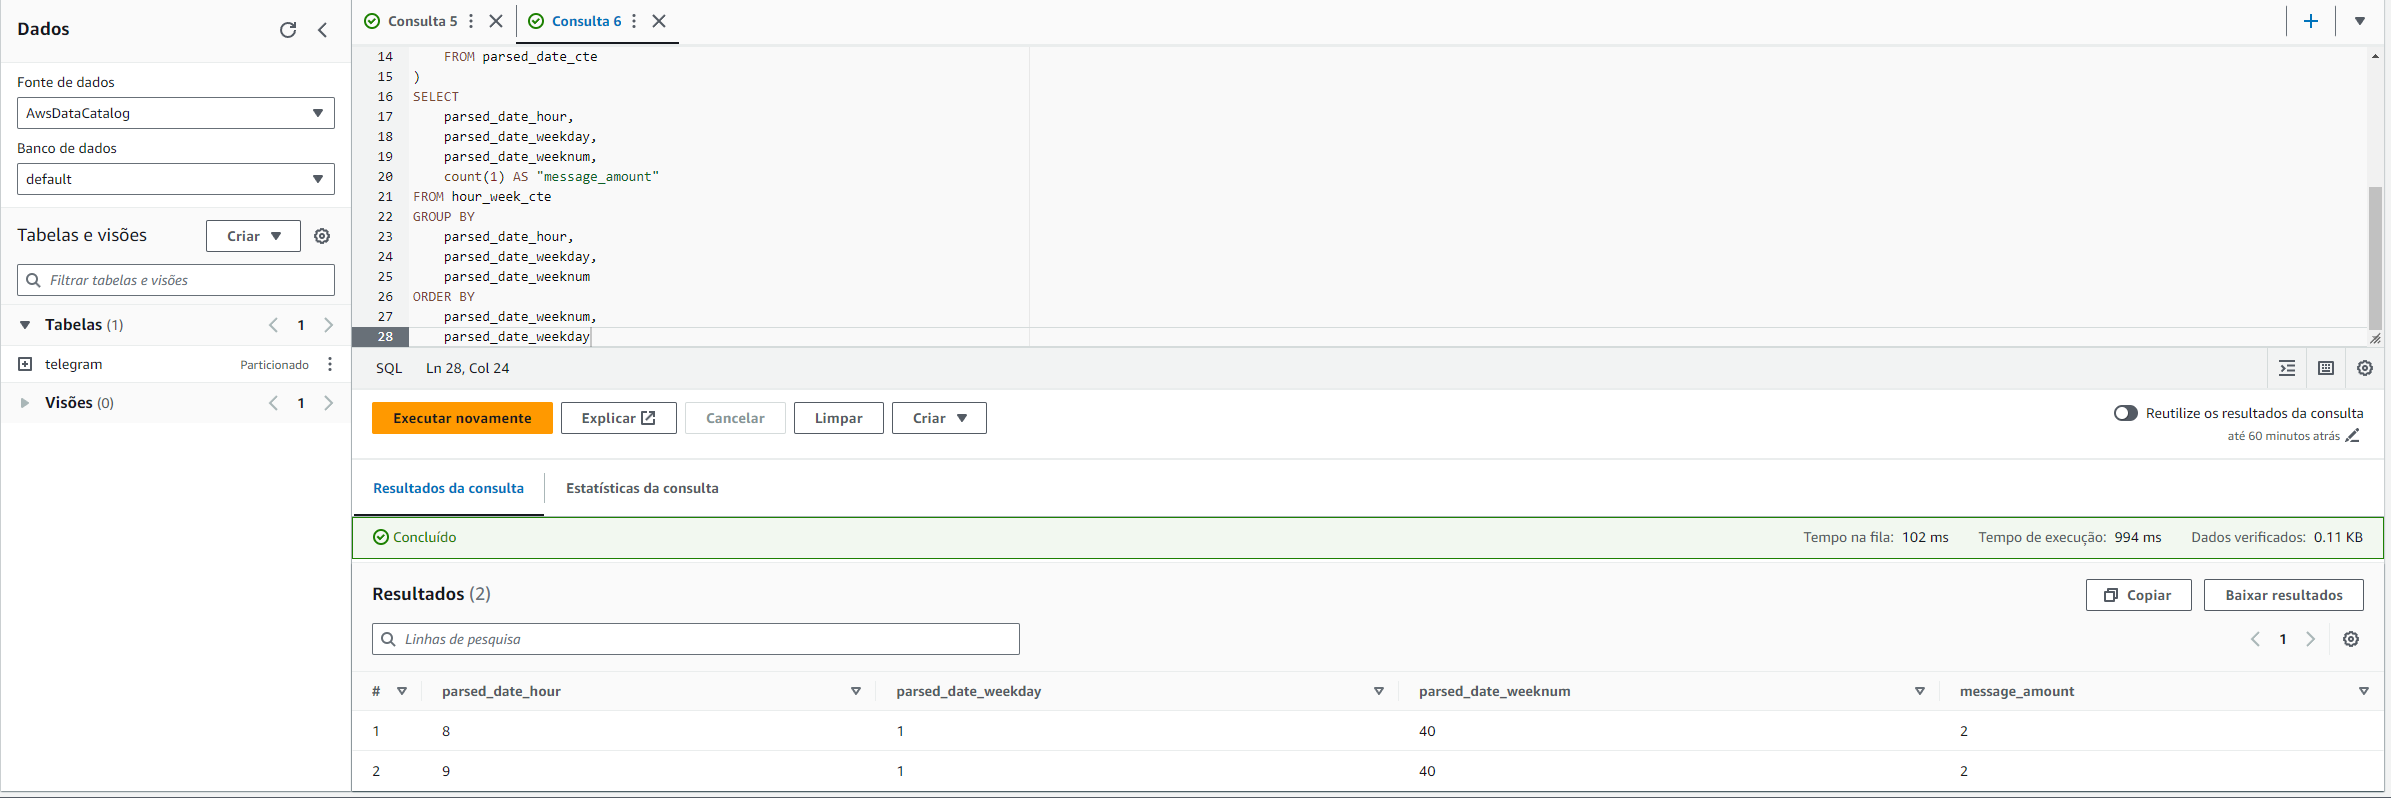

> A consulta retorna a hora, dia da semana, a semana e a quantidade de mensagens enviadas.
